# Preperation

### Imports

In [18]:
import pandas as pd
import textstat
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

### Paths

In [ ]:
import sys, os
sys.path.append(os.path.abspath('../../src'))
from helper_functions.path_resolver import DynamicPathResolver

Project Root: c:\Users\ilian\Documents\Projects\git_projects\university\phishing_detection


In [ ]:
dpr = DynamicPathResolver(marker="README.md")

train_raw = dpr.path.data.raw.data_mail.train_raw_balanced_csv
test_raw = dpr.path.data.raw.data_mail.test_raw_en_de_csv

train_preprocessed = dpr.path.data.preprocessed.data_meta.train_processed_balanced_csv
test_preprocessed  = dpr.path.data.preprocessed.data_meta.test_processed_en_de_csv

models_folder = dpr.path.models.meta
output_dir    = dpr.path.models.meta.results

### Functions

In [21]:
def perform_correlation_analysis(df, threshold=0.95):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    to_drop = [col for col in upper.columns if any(upper[col] > threshold)]
    correlated_features = {col: upper[col][upper[col] > threshold].index.tolist() for col in to_drop}
    remaining_features = [col for col in df.columns if col not in to_drop]

    print("\n**Feature Correlation Report**")
    print(f"- Correlation Threshold: {threshold}")
    print(f"- Features Removed: {len(to_drop)}")
    print(f"- Remaining Features: {len(remaining_features)}")

    for key, value in correlated_features.items():
        print(f"- {key} is highly correlated with: {value}")

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
    plt.title("Feature Correlation Heatmap")
    plt.show()

    return remaining_features, correlated_features


def perform_feature_correlation(df, feature_columns):
    remaining_features, correlated_report = perform_correlation_analysis(df[feature_columns])
    return remaining_features


In [22]:
def extract_features(df):
    df['subject_length'] = df['subject'].apply(len)
    df['body_length'] = df['body'].apply(len)
    df['special_char_count'] = df['body'].apply(lambda x: len(re.findall(r'[!@#$%^&*(),.?":{}|<>]', x)))
    df['digit_count'] = df['body'].apply(lambda x: len(re.findall(r'\d', x)))
    df['url_count'] = df['body'].apply(lambda x: len(re.findall(r'https?://\S+|www\.\S+', x)))
    df['uppercase_word_count'] = df['body'].apply(lambda x: len([word for word in x.split() if word.isupper()]))
    df['exclamation_mark_count'] = df['body'].apply(lambda x: x.count('!'))
    df['question_mark_count'] = df['body'].apply(lambda x: x.count('?'))
    df['word_count'] = df['body'].apply(lambda x: len(x.split()))
    df['avg_word_length'] = df['body'].apply(lambda x: np.mean([len(word) for word in x.split()]) if x.split() else 0)
    df['html_tag_count'] = df['body'].apply(lambda x: len(re.findall(r'<[^>]+>', x)))
    df['repeated_char_count'] = df['body'].apply(lambda x: len(re.findall(r'(.)\1{2,}', x)))
    df['email_address_count'] = df['body'].apply(lambda x: len(re.findall(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', x)))
    df['readability_score'] = df['body'].apply(lambda x: textstat.flesch_reading_ease(x))
    return df


def process_text_columns(df):
    df['subject'] = df['subject'].fillna('').astype(str)
    df['body'] = df['body'].fillna('').astype(str)
    return df

In [ ]:
def preprocess_and_save_data(train_file, test_file, train_save_path, test_save_path):
    feature_columns = [
        'subject_length', 'body_length', 'special_char_count', 'digit_count', 'url_count',
        'uppercase_word_count', 'exclamation_mark_count', 'question_mark_count',
        'word_count', 'avg_word_length', 'html_tag_count', 'repeated_char_count',
        'email_address_count', 'readability_score'
    ]

    df_train = pd.read_csv(train_file)
    df_test = pd.read_csv(test_file)

    df_train = process_text_columns(df_train)
    df_test = process_text_columns(df_test)

    df_train = extract_features(df_train)
    df_test = extract_features(df_test)

    remaining_features = perform_feature_correlation(df_train, feature_columns)

    df_train = df_train[remaining_features + ['label', 'body']]
    df_test = df_test[remaining_features + ['label', 'body']]

    df_train.to_csv(train_save_path, index=False)
    df_test.to_csv(test_save_path, index=False)

    print("Preprocessed & saved")

### Preprocess data


**Feature Correlation Report**
- Correlation Threshold: 0.95
- Features Removed: 3
- Remaining Features: 11
- special_char_count is highly correlated with: ['body_length']
- word_count is highly correlated with: ['body_length']
- readability_score is highly correlated with: ['avg_word_length']


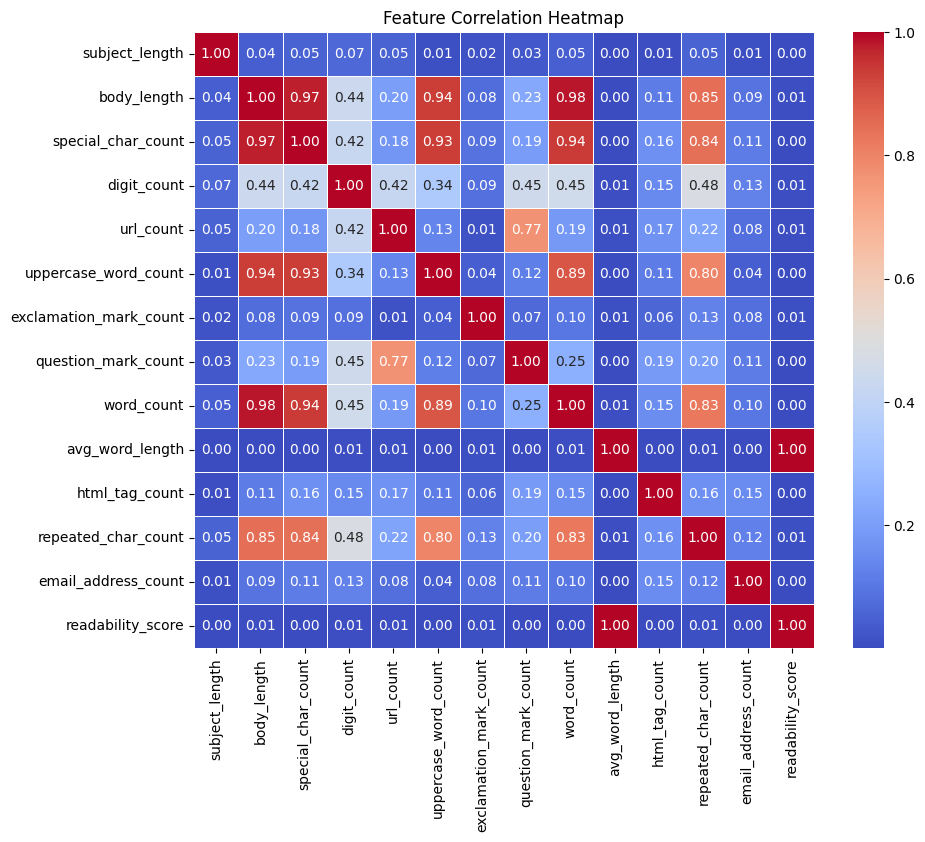

Preprocessed & saved


In [24]:
preprocess_and_save_data(train_raw, test_raw, train_preprocessed, test_preprocessed)